# Initial Analysis of Time Series

## First Option - Electricity consumption in Brazil - residential [1975-2025]

In [25]:
import pandas as pd
import requests

url = f"https://api.bcb.gov.br/dados/serie/bcdata.sgs.1403/dados?formato=json"
response = requests.get(url)

if response.status_code == 200:
    # Converter para DataFrame
    data = pd.DataFrame(response.json())
    data["data"] = pd.to_datetime(data["data"], dayfirst=True)
    data["valor"] = data["valor"].astype(float) 

    
    print(data.head(10))
else:
    print("Erro ao acessar a API:", response.status_code)


        data   valor
0 1979-02-01  1647.0
1 1979-03-01  1736.0
2 1979-04-01  1681.0
3 1979-05-01  1757.0
4 1979-06-01  1689.0
5 1979-07-01  1730.0
6 1979-08-01  1697.0
7 1979-09-01  1809.0
8 1979-10-01  1789.0
9 1979-11-01  1840.0


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

data = data.sort_values("data")  # Sorting in ascending order
data.set_index("data", inplace=True)  # Confirm data as index for TS

stats = data["valor"].describe()
stats


count      552.000000
mean      7054.106884
std       3629.927195
min       1647.000000
25%       4033.000000
50%       6642.500000
75%      10285.500000
max      15637.000000
Name: valor, dtype: float64

/tmp/ipykernel_11310/2328046960.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


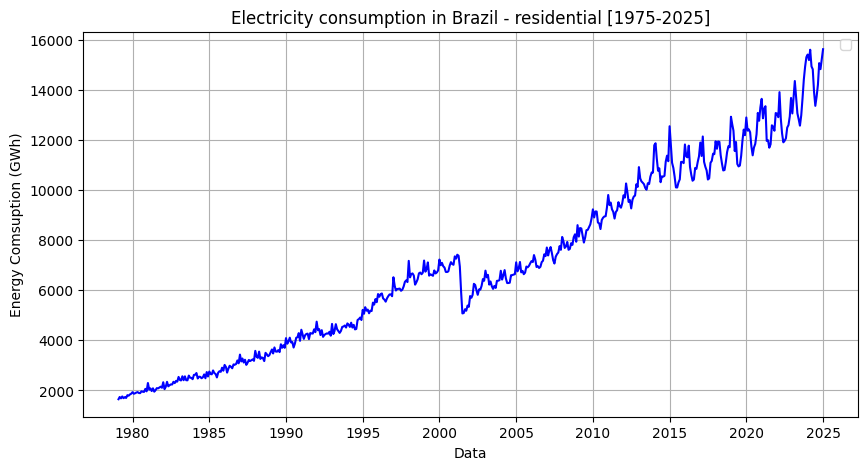

In [27]:
# TS Pre Visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(data.index, data["valor"], color='blue')
plt.xlabel("Data")
plt.ylabel("Energy Comsuption (GWh)")
plt.title("Electricity consumption in Brazil - residential [1975-2025]")
plt.legend()
plt.grid()
plt.show()

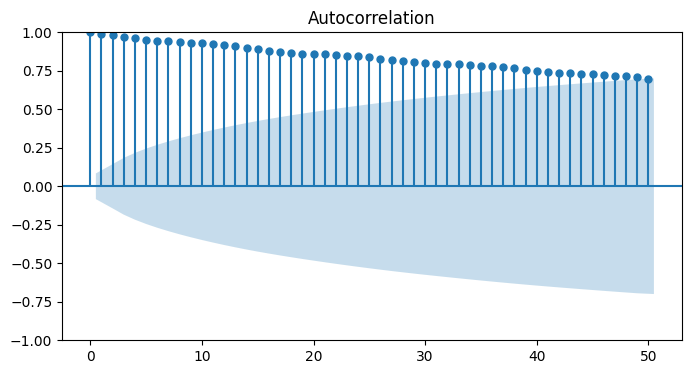

In [13]:

# 3. Gráfico de autocorrelação (FAC)
fig, ax = plt.subplots(figsize=(8, 4))
sm.graphics.tsa.plot_acf(data["valor"], lags=50, ax=ax)
plt.show()

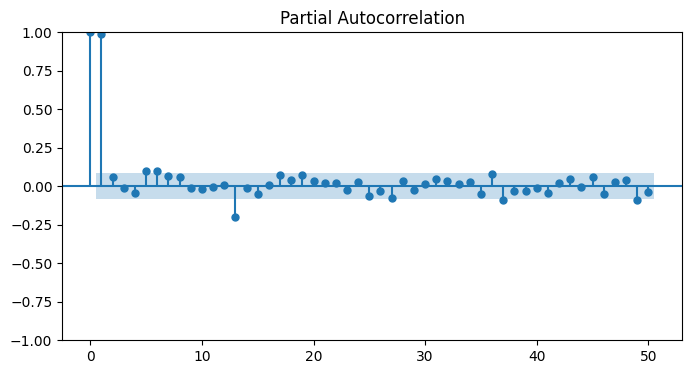

In [14]:
# 4. Gráfico de autocorrelação parcial (FACP)
fig, ax = plt.subplots(figsize=(8, 4))
sm.graphics.tsa.plot_pacf(data["valor"], lags=50, ax=ax)
plt.show()


In [15]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Executar o Teste de Dickey-Fuller (ADF)
adf_test = adfuller(data["valor"])

adf_results = {
    "Estatística ADF": adf_test[0],
    "Valor-p": adf_test[1],
    "Nº de Lags": adf_test[2],
    "Nº de Observações": adf_test[3],
    "Valores Críticos": adf_test[4] 
}

adf_df = pd.DataFrame(adf_results.items(), columns=["Métrica", "Valor"])

adf_df

,Métrica,Valor
0,Estatística ADF,1.432084
1,Valor-p,0.997255
2,Nº de Lags,18
3,Nº de Observações,533
4,Valores Críticos,"{'1%': -3.442678467240966, '5%': -2.8669778698..."


In [16]:
adf_df[adf_df.Métrica == 'Valores Críticos'].values

array([['Valores Críticos',
        {'1%': np.float64(-3.442678467240966), '5%': np.float64(-2.8669778698997543), '10%': np.float64(-2.5696661916864083)}]],
      dtype=object)

## Second Option - commodity index - Brazil -Agriculture [2010-2025]


In [17]:
import pandas as pd
import requests

url = f"https://api.bcb.gov.br/dados/serie/bcdata.sgs.24769/dados?formato=json"
response = requests.get(url)

if response.status_code == 200:
    # Converter para DataFrame
    data = pd.DataFrame(response.json())
    data["data"] = pd.to_datetime(data["data"], dayfirst=True)
    data["valor"] = data["valor"].astype(float) 

    
    print(data.head(10))
else:
    print("Erro ao acessar a API:", response.status_code)


        data  valor
0 2010-01-01   26.4
1 2010-02-01   25.4
2 2010-03-01   32.3
3 2010-04-01   30.1
4 2010-05-01   29.0
5 2010-06-01   32.3
6 2010-07-01   33.2
7 2010-08-01   34.1
8 2010-09-01   35.3
9 2010-10-01   35.1


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

data = data.sort_values("data")  # Sorting in ascending order
data.set_index("data", inplace=True)  # Confirm data as index for TS

stats = data["valor"].describe()
stats


count    181.000000
mean      33.718232
std       10.980855
min       11.400000
25%       26.000000
50%       32.100000
75%       39.100000
max       81.800000
Name: valor, dtype: float64

/tmp/ipykernel_11310/271406417.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


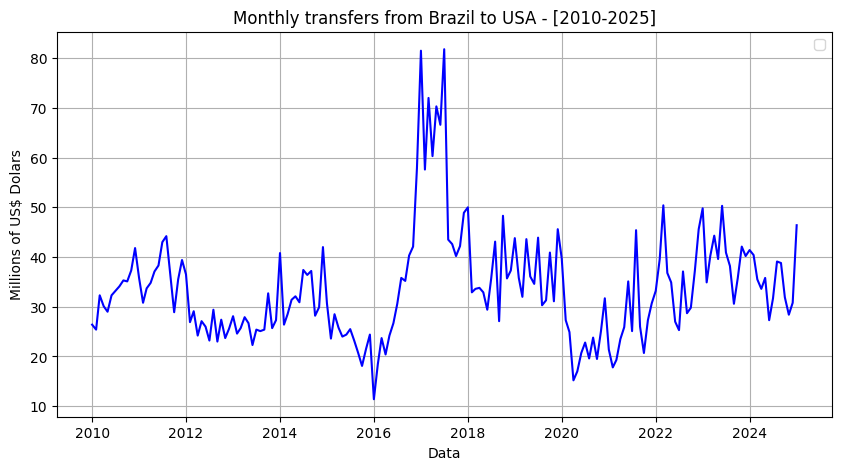

In [19]:
# TS Pre Visualization
plt.figure(figsize=(10, 5))
plt.plot(data.index, data["valor"], color='blue')
plt.xlabel("Data")
plt.ylabel("Millions of US$ Dolars")
plt.title("Monthly transfers from Brazil to USA - [2010-2025]")
plt.legend()
plt.grid()
plt.show()

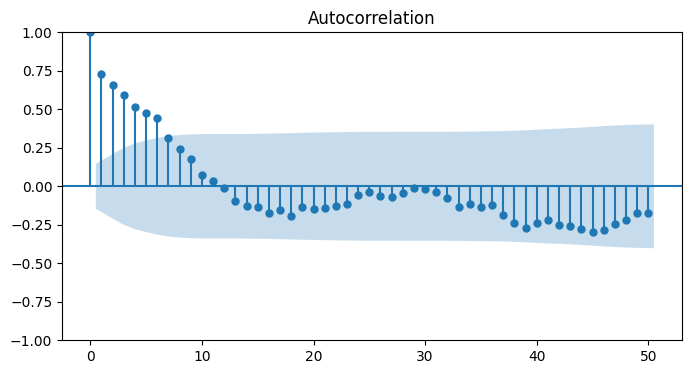

In [20]:

# 3. Gráfico de autocorrelação (FAC)
fig, ax = plt.subplots(figsize=(8, 4))
sm.graphics.tsa.plot_acf(data["valor"], lags=50, ax=ax)
plt.show()

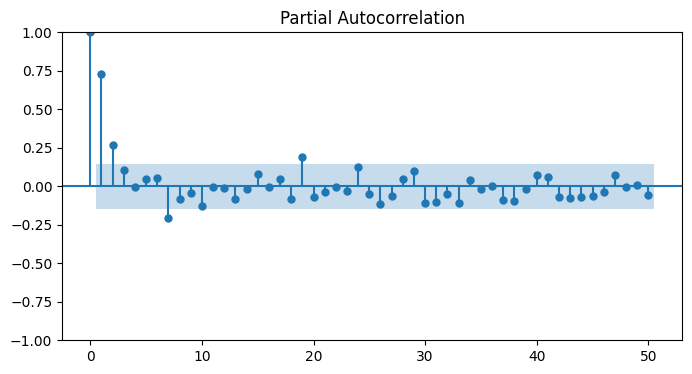

In [21]:
# 4. Gráfico de autocorrelação parcial (FACP)
fig, ax = plt.subplots(figsize=(8, 4))
sm.graphics.tsa.plot_pacf(data["valor"], lags=50, ax=ax)
plt.show()


In [22]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Executar o Teste de Dickey-Fuller (ADF)
adf_test = adfuller(data["valor"])

# Criar um dicionário com os resultados
adf_results = {
    "Estatística ADF": adf_test[0],
    "Valor-p": adf_test[1],
    "Nº de Lags": adf_test[2],
    "Nº de Observações": adf_test[3],
    "Valores Críticos": adf_test[4] 
}

adf_df = pd.DataFrame(adf_results.items(), columns=["Métrica", "Valor"])

adf_df

,Métrica,Valor
0,Estatística ADF,-3.13797
1,Valor-p,0.023868
2,Nº de Lags,6
3,Nº de Observações,174
4,Valores Críticos,"{'1%': -3.4685016947910636, '5%': -2.878298366..."


In [23]:
adf_df[adf_df.Métrica == 'Valores Críticos'].values

array([['Valores Críticos',
        {'1%': np.float64(-3.4685016947910636), '5%': np.float64(-2.8782983668563396), '10%': np.float64(-2.57570415906989)}]],
      dtype=object)